## 1. Structure Dataset

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
# funcs stolen from nyu deep learning course
from res.sequential_tasks import pad_sequences, to_categorical
import os

In [11]:
data_path = '/Users/evanrussek/Dropbox/Griffiths_Lab_Stuff/Data/RNNs/optimal_fixation_sims'
# os.path.join(to_save_folder, file_name)
train_file_idxs = range(1,16)
test_file_idxs = range(16,31)

train_files = [os.path.join(data_path, str(i) + '.json') for i in train_file_idxs]
test_files = [os.path.join(data_path, str(i) + '.json') for i in test_file_idxs]

a = [json.load(open(train_files[i])) for i in range(15)]
train_trials = [item for sublist in a for item in sublist]
del a
train_data_sim = train_trials[:int(1e6)]

test_trials = json.load(open(test_files[0]))
test_data_sim = test_trials[:int(1e5)]

human_data_path = '/Users/evanrussek/Dropbox/Griffiths_Lab_Stuff/Data/RNNs/human_trials.json'
human_trials = json.load(open(human_data_path))

In [63]:
human_trials[0]

{'choice': 3,
 'value': [4, 2, 3],
 'fixations': [1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3]}

In [64]:
def gen_batch_data(batch_size, batch_idx, sim_data, human_data=False):
# can you also pass the index on which this starts... 
#sim_data = train_data_sim
#batch_idx = 0
#batch_size = 32

    """
    Create sequence and target data for a batch

    Input: 
        batch_size: number of trials to include in batch
        batch_idx: index of data
        sim_data: list of dicts, where each dict has 'values', 'fixations', and 'choice'

    Returns:
        a tuple, (batch_data, batch_targets)
        batch_data is 3d array: batch_size x sequence_size x one-hot categorical encoding (3 here)
        batch_targets is 2d array: 
    """

    # filter list of trials that are in this batch
    batch_sim_data = sim_data[batch_idx*batch_size:((batch_idx+1)*(batch_size))]

    ## generate sequences of fixations + choice

    # all sequences in the batch, attended item is coded as idx (as 0, 1, 2)
    if human_data:
        batch_sequences_idx = [(np.array(trial_data['fixations'])-1).tolist() for trial_data in batch_sim_data]
    else:
        batch_sequences_idx = [trial_data['fixations'] for trial_data in batch_sim_data]

    
    # all sequences in the batch, attended item is coded as idx (as 0, 1, 2)
    batch_choices_idx = [trial_data['choice'] - 1 for trial_data in batch_sim_data]

    # first 3 are fixation, last is choice...
    batch_sequences_cat = [[to_categorical(x, num_classes = 6) for x in this_sequence] for this_sequence in batch_sequences_idx]

    # now append to each of these the choice info - the choice gets it's own channel (of 3)
    batch_sequences_cat_w_choices = [batch_sequences_cat[i] + [to_categorical(3 + batch_choices_idx[i], num_classes = 6)] for i in range(len(batch_sequences_cat))]
    batch_data = pad_sequences(batch_sequences_cat_w_choices)
    batch_data = batch_data.astype('float32')

    batch_targets_init = np.array([trial_data['value'] for trial_data in batch_sim_data], dtype = 'float32')
    batch_targets_cont = [np.repeat([batch_targets_init[i]],len(batch_sequences_cat_w_choices[i]),axis=0) for i in range(len(batch_sequences_cat_w_choices))]
    #batch_targets_cont = [np.repeat([batch_targets_init[i]],len(batch_sequences_cat[i]),axis=0) for i in range(len(batch_sequences_cat))]

    batch_targets = pad_sequences(batch_targets_cont)
    batch_targets = batch_targets.astype('float32')
    
    first_fixations = np.array([np.where(batch_targets[i,:,:] != [0,0,0])[0][0] for i in range(batch_targets.shape[0])])
    

    return (batch_data, batch_targets)

In [65]:
def gen_batch_data_choice_only(batch_size, batch_idx, sim_data, human_data=False):
    # filter list of trials that are in this batch
    batch_sim_data = sim_data[batch_idx*batch_size:((batch_idx+1)*(batch_size))]

    # all sequences in the batch, attended item is coded as idx (as 0, 1, 2)
    batch_choices_idx = [trial_data['choice'] - 1 for trial_data in batch_sim_data]

    batch_data = to_categorical(batch_choices_idx)
    batch_data = batch_data.astype('float32')

    batch_targets = np.array([trial_data['value'] for trial_data in batch_sim_data], dtype = 'float32')
    batch_targets= batch_targets.astype('float32')
    return (batch_data, batch_targets)


In [66]:
example_batch = gen_batch_data(32, 0, human_trials,human_data=True) # batch size = 32, idx = 0
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of targets with shape {example_batch[1].shape}.')
print(f'The first element in the batch of targets is:\n {example_batch[1][0, :]}')
# print(f'The first element in fixations is:\n {example_batch[2][0]}')


The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 139, 6).
The first element in the batch of sequences is:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set the random seed for reproducible results

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x
    
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c
    
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.input_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_output = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        ha = self.input_hidden(x)
        hb = F.relu(ha)
        o = self.hidden_output(hb)
        return o


In [40]:
# that's for train data... what about test...
# Define the testing loop
def test(model, test_sim_data, criterion, device, batch_size, n_total_seq, gen_batch_data):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()
    
    n_total_seq = 1000

    n_batches = int(np.round(n_total_seq / batch_size));

    loss_res = np.zeros((n_batches, 1), dtype=float)

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(n_batches):
            data, target = gen_batch_data(batch_size, batch_idx, test_sim_data)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            
            to_keep = target != 0
            target = target[to_keep]
            output = output[to_keep]
            
            
            # Pick only the output corresponding to last sequence element (input is pre padded)
            # output = output[:, -1, :]

            # target = target.argmax(dim=1)
            loss = criterion(output, target)  # is this just for the last batch?

            # store the loss
            loss_res[batch_idx] = loss.item()

    return np.mean(loss_res)

In [41]:
from IPython import display
from IPython.display import clear_output


def train_with_int_tests(model, train_sim_data, test_sim_data, criterion, optimizer, device, batch_size, n_total_seq, gen_batch_data, model_name = ""):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()
    
    # What metric to store?
    # num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
        
    # how many batches
    n_batches = int(np.round(n_total_seq/batch_size));
    
    loss_res = []
    train_loss_res = []
    batch_num = []

    for batch_idx in range(n_batches):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        #data, target = train_data_gen[batch_idx] # just alter this to the function that produces the data?
        data, target = gen_batch_data(batch_size, batch_idx, train_sim_data)
        
        # this needs to change... 
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        
        # for some reason target is an int, and dosn't match the output which is float32
        target = target.to(torch.float32)
        
        # remove padding (nicely, this is just 0's)
        to_keep = target != 0
        target = target[to_keep]
        output = output[to_keep]
        
        # need to re-write this function... 
        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤
        
        if ((batch_idx % 250) == 0) & (batch_idx > 0):
            test_loss = test(model, test_data_sim, criterion, device, batch_size, n_total_seq, gen_batch_data)
            loss_res.append(test_loss)
            
            train_loss_res.append(loss.item())
            batch_num.append(batch_idx+1)
            
            clear_output(wait=False)
            plt.figure(figsize=(5,5))
            plt.plot(np.arange(1,len(loss_res)+1)*250*32, loss_res)
            #plt.plot(range(len(train_loss_res)), train_loss_res)
            plt.xlabel('# train examples')
            plt.ylabel('MSE')
            plt.title(model_name)
            plt.show();

            print('batch num' + str(batch_idx) + ' loss: ' + str(test_loss))

    #return num_correct, loss.item()
    return model, loss_res, batch_num#loss.item()

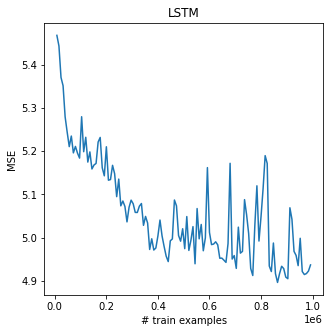

batch num31000 loss: 4.937163614457654
--- 1110.5733351707458 seconds ---


In [42]:
import time

# Setup the training and test data generators
batch_size     = 32
n_total_seq = 1e6
n_batches = int(np.round(n_total_seq/batch_size));
n_tests = int(np.ceil(n_batches/250)) - 1

n_runs = 1
LSTM_run_losses = np.zeros((n_runs, n_tests))
for run_idx in range(n_runs):
    torch.manual_seed(run_idx)

    print(run_idx)

    # Setup the RNN and training settings
    input_size  = 6 # this is the length of the input vector? #train_data_gen.n_symbols
    hidden_size = 50
    output_size = 3 # this is the leågth of the output vector #train_data_gen.n_classes
    model       = SimpleLSTM(input_size, hidden_size, output_size)
    criterion   = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
    optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
    # optimizer   = torch.optim.Adam(model.parameters(), lr=0.00304)
    max_epochs  = 10
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Train the model›
    # model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)
    start_time = time.time()
    # model_LSTM = train_and_test(model, train_data_sim, test_data_sim, criterion, optimizer, max_epochs, batch_size, n_total_seq, verbose=True, model_name = 'LSTM')
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model_LSTM, loss_res, LSTM_batch_num = train_with_int_tests(model, train_data_sim, test_data_sim, criterion, optimizer, device, batch_size, n_total_seq, gen_batch_data, model_name='LSTM')
    LSTM_run_losses[run_idx,:] = loss_res
    print("--- %s seconds ---" % (time.time() - start_time))

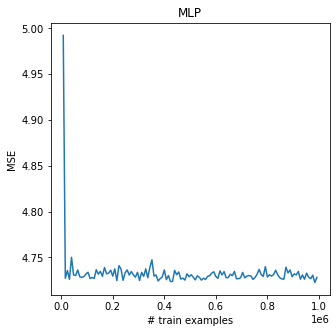

batch num31000 loss: 4.728334196152225


ValueError: could not broadcast input array from shape (124,) into shape (125,)

In [58]:
# Setup the training and test data generators
batch_size     = 32
n_total_seq = 1e6
n_batches = int(np.round(n_total_seq/batch_size));
n_tests = int(np.floor(n_batches/250))

n_runs = 1
MLP_run_losses = np.zeros((n_runs, n_tests))
for run_idx in range(n_runs):
    
    # Setup the RNN and training settings
    input_size  = 3 # this is the length of the input vector? #train_data_gen.n_symbols
    hidden_size = 50
    output_size = 3 # this is the leågth of the output vector #train_data_gen.n_classes
    model       = SimpleMLP(input_size, hidden_size, output_size)
    criterion   = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
    optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
    # optimizer   = torch.optim.Adam(model.parameters(), lr=0.00304)
    max_epochs  = 10
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


    # Train the model›
    # model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)
    start_time = time.time()
    # model_LSTM = train_and_test(model, train_data_sim, test_data_sim, criterion, optimizer, max_epochs, batch_size, n_total_seq, verbose=True, model_name = 'LSTM')
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model_MLP, loss_res, batch_num = train_with_int_tests(model, train_data_sim, test_data_sim, criterion, optimizer, device, batch_size, n_total_seq, gen_batch_data_choice_only,model_name='MLP')
    MLP_run_losses[run_idx,:] = loss_res
    print("--- %s seconds ---" % (time.time() - start_time))

In [49]:
def test_record_each_output(model, test_sim_data, criterion, device, batch_size, n_total_seq, gen_batch_data,out_idx, choice_only=False, human_data=False):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    
    # print(choice_only)
    model.eval()

    # Store the number of sequences that were classified correctly
    # num_correct = 0

    n_batches = int(np.round(n_total_seq/batch_size));

    output_all = np.zeros((0,3))
    target_all = np.zeros((0,3))

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(n_batches):
            data, target = gen_batch_data(batch_size, batch_idx, test_sim_data, human_data = human_data)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            if not choice_only:
                output = output[:, -out_idx, :]
                target = target[:,-out_idx,:]

            output_all = np.concatenate((output_all, output.numpy()))
            target_all = np.concatenate((target_all, target.numpy()))

    return (output_all, target_all)



Text(0.5, 1.0, 'LSTM Performance, MSE: 4.25 , r: 0.59 ')

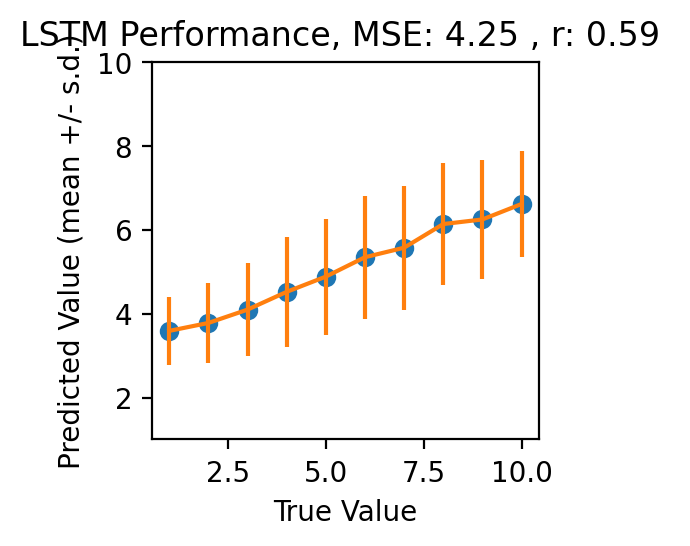

In [46]:
# most test data
n_total_seq_vis = 3e3
output_all_LSTM, target_all_LSTM = test_record_each_output(model_LSTM, test_data_sim, criterion, device, batch_size, n_total_seq_vis,gen_batch_data, 1)
output_flat = output_all_LSTM.flatten()
target_flat = target_all_LSTM.flatten()

r = np.round(np.corrcoef(output_flat, target_flat)[1][0], decimals = 2)
mse = np.round(np.mean(np.power(output_flat - target_flat,2)), decimals=2)
target_flat_round = np.round(target_flat)
mean_estimates = np.zeros(10)
std_estimates = np.zeros(10)
for i in range(1,11):
    mean_estimates[i-1] = np.mean(output_flat[target_flat_round == i])
    std_estimates[i-1] = np.std(output_flat[target_flat_round == i])

fix,ax = plt.subplots(1,figsize = (2.5,2.5), dpi = 200)
ax.plot(range(1,11), mean_estimates, 'o')
ax.errorbar(range(1,11), mean_estimates, yerr = std_estimates)
ax.set_ylim([1,10])
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value (mean +/- s.d.)')
ax.set_title('LSTM Performance, MSE: {} , r: {} '.format(mse,r))

Text(0.5, 1.0, 'LSTM Performance, MSE: 5.08 , r: 0.47 ')

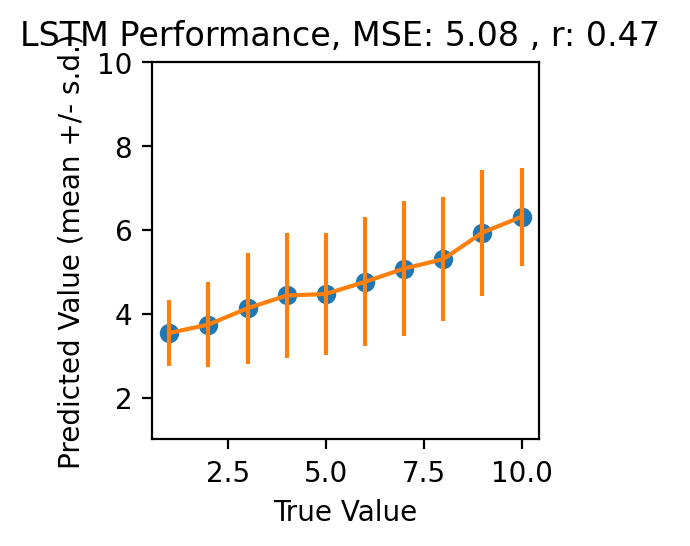

In [53]:

n_total_seq_vis = len(human_trials)
output_all_LSTM, target_all_LSTM = test_record_each_output(model_LSTM, human_trials, criterion, device, batch_size, n_total_seq_vis,gen_batch_data, 1, human_data=True)
output_flat = output_all_LSTM.flatten()
target_flat = target_all_LSTM.flatten()

r = np.round(np.corrcoef(output_flat, target_flat)[1][0], decimals = 2)
mse = np.round(np.mean(np.power(output_flat - target_flat,2)), decimals=2)
target_flat_round = np.round(target_flat)
mean_estimates = np.zeros(10)
std_estimates = np.zeros(10)
for i in range(1,11):
    mean_estimates[i-1] = np.mean(output_flat[target_flat_round == i])
    std_estimates[i-1] = np.std(output_flat[target_flat_round == i])

fix,ax = plt.subplots(1,figsize = (2.5,2.5), dpi = 200)
ax.plot(range(1,11), mean_estimates, 'o')
ax.errorbar(range(1,11), mean_estimates, yerr = std_estimates)
ax.set_ylim([1,10])
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value (mean +/- s.d.)')
ax.set_title('LSTM Performance, MSE: {} , r: {} '.format(mse,r))

Text(0, 0.5, 'r: prediction vs target')

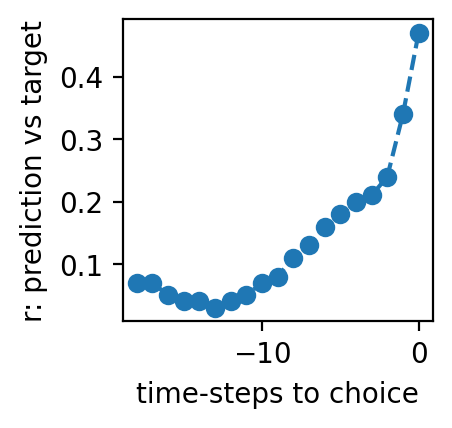

In [56]:
# can you record from starting at end and moving backward... 

n_back_vals = np.arange(1,20)
r_by_n_back = np.zeros(len(n_back_vals))

n_total_seq_vis = len(human_trials)

for nb_idx, nb in enumerate(n_back_vals):
    output_all_LSTM, target_all_LSTM = test_record_each_output(model_LSTM, human_trials, criterion, device, batch_size, n_total_seq_vis,gen_batch_data,nb, human_data=True)
    output_flat = output_all_LSTM.flatten()
    target_flat = target_all_LSTM.flatten()
    output_flat = output_flat[target_flat != 0]
    target_flat = target_flat[target_flat != 0]

    r = np.round(np.corrcoef(output_flat, target_flat)[1][0], decimals = 2)
    r_by_n_back[nb_idx] = r
    
fig,ax = plt.subplots(1,figsize=(2,2),dpi=200)
ax.plot(-1*n_back_vals+1,r_by_n_back, '--o')
ax.set_xlabel('time-steps to choice')
ax.set_ylabel('r: prediction vs target')

Text(0.5, 1.0, 'MLP Performance, MSE: 4.73 , r: 0.5 ')

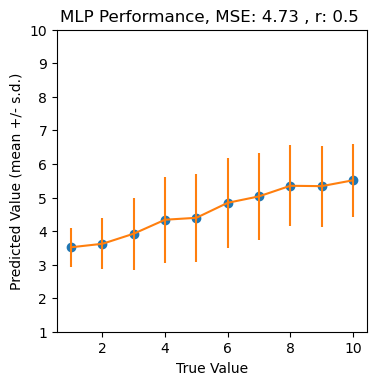

In [61]:
n_total_seq_vis = 1e3
output_all_MLP, target_all_MLP = test_record_each_output(model_MLP, test_data_sim, criterion, device, batch_size, n_total_seq_vis, gen_batch_data_choice_only,0, choice_only=True)
output_flat = output_all_MLP.flatten()
target_flat = target_all_MLP.flatten()

r = np.round(np.corrcoef(output_flat, target_flat)[1][0], decimals = 2)
mse = np.round(np.mean(np.power(output_flat - target_flat,2)), decimals=2)
target_flat_round = np.round(target_flat)
mean_estimates = np.zeros(10)
std_estimates = np.zeros(10)
for i in range(1,11):
    mean_estimates[i-1] = np.mean(output_flat[target_flat_round == i])
    std_estimates[i-1] = np.std(output_flat[target_flat_round == i])

fix,ax = plt.subplots(1,figsize = (4,4), dpi = 100)
ax.plot(range(1,11), mean_estimates, 'o')
ax.errorbar(range(1,11), mean_estimates, yerr = std_estimates)
ax.set_ylim([1,10])
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value (mean +/- s.d.)')
ax.set_title('MLP Performance, MSE: {} , r: {} '.format(mse,r))

Text(0.5, 1.0, 'MLP Performance, MSE: 4.9 , r: 0.49 ')

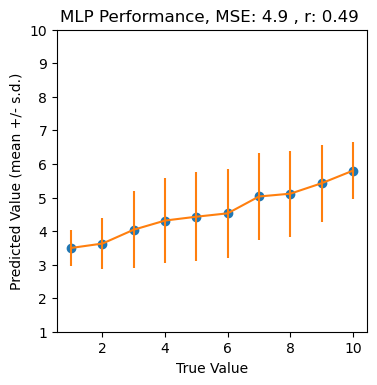

In [62]:
n_total_seq_vis = 1e3
output_all_MLP, target_all_MLP = test_record_each_output(model_MLP, human_trials, criterion, device, batch_size, n_total_seq_vis, gen_batch_data_choice_only,0, choice_only=True)
output_flat = output_all_MLP.flatten()
target_flat = target_all_MLP.flatten()

r = np.round(np.corrcoef(output_flat, target_flat)[1][0], decimals = 2)
mse = np.round(np.mean(np.power(output_flat - target_flat,2)), decimals=2)
target_flat_round = np.round(target_flat)
mean_estimates = np.zeros(10)
std_estimates = np.zeros(10)
for i in range(1,11):
    mean_estimates[i-1] = np.mean(output_flat[target_flat_round == i])
    std_estimates[i-1] = np.std(output_flat[target_flat_round == i])

fix,ax = plt.subplots(1,figsize = (4,4), dpi = 100)
ax.plot(range(1,11), mean_estimates, 'o')
ax.errorbar(range(1,11), mean_estimates, yerr = std_estimates)
ax.set_ylim([1,10])
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value (mean +/- s.d.)')
ax.set_title('MLP Performance, MSE: {} , r: {} '.format(mse,r))